##### Installing Julia packages (only needs to be done once)

In [ ]:
import Pkg;

Pkg.add(url="https://github.com/Marc-3d/LIBTIFF.jl.git")
Pkg.add(url="https://github.com/Marc-3d/multi_quickPIV.git")
Pkg.add(url="https://github.com/Marc-3d/ImageAnalysis.git")

# VISUALIZATION PACKAGES
#   PyPlot is very popular and great for generating non-interactive Plots
#   ImageView a simple visualization package, similar to Fiji, allowing to scroll through timepoints in a 2D+t dataset
#   Makie is great for interactive visulization, but it is a big package. It might take a bit to install/compile.

Pkg.add("PyCall")
Pkg.add("PyPlot")
Pkg.add("ImageView")
Pkg.add("Makie") 

# IMAGE PROCESSING and IMAGE-RELATED PACKAGES
Pkg.add("Images")
Pkg.add("ImageMorphology")
Pkg.add("ImageComponentAnalysis")
Pkg.add("ImageDraw")
Pkg.add("ColorTypes")
Pkg.add("ColorSchemes")
Pkg.add("DistanceTransforms")

##### Importing Julia packages

In [2]:
using LIBTIFF, FileIO, JLD2
using multi_quickPIV, ImageAnalysis
using GLMakie, ImageView, PyPlot, PyCall
using Images, ImageMorphology, ImageComponentAnalysis, ImageDraw, ColorTypes, DistanceTransforms, ColorSchemes

# importing pipeline scripts 
script_path = joinpath( pwd(), "scripts" ); 
include( joinpath( script_path, "vf_utils.jl" ) )
include( joinpath( script_path, "wave_utils.jl" ) )
include( joinpath( script_path, "data_utils.jl" ) )
include( joinpath( script_path, "makie_utils.jl" ) )
include( joinpath( script_path, "segment_utils.jl" ) )
include("wave_segmentation_Pereyra_etal.jl")

paint_VD! (generic function with 1 method)

##### Generating/Loading 2D+t lateral maximum intensity projections

It is (much) faster and simpler to load the pre-computed max projections within ```lateral_2Dt_results.jld2```. <br>

You can chose to re-generate them from the 3D fused volumes: ... to ....  <br>

In both cases you need to download the data from ZENODO and set up the path to the files in the code below.

In [4]:
load_from_jld2 = true

if load_from_jld2
    
    jld2_dir    = ""; 
    jld2_dir    = "R:/users/pereyram/SHARING/Wave_detection_paper_movies/"
    jld2_path   = joinpath( jld2_dir, "lateral_2Dt_results.jld2" ); 
    
    lateral_2Dt = load( jld2_path, "max_projections" );
    
    N_tps = size( lateral_2Dt, 3 ); 
    
else # it takes a while. 20 minutes for me.
    
    volume_dir  = "";
    volume_fn   = ""; 
    volume_dir  = "R:/users/pereyram/TMP_BACKUP/volumes/"
    volume_fn   = "fused_tp_233_ch_0.tif";
    volume_path = joinpath( volume_dir, volume_fn )
    
    tp_regex    = Regex( "tp_(\\d+)" ); 
    tp0, tp1    = 233, 332; 
    N_tps       = tp1 - tp0 + 1; 
    lateral_2Dt = generate_lateral_projections( volume_path, tp_regex, tp0, tp1 )
end;

In [5]:
visualize_data = true

if visualize_data
    
    clim = ImageView.default_clim( ones( Float32, 1, 1 ) .* ( 1, 300 ) )
    ImageView.imshow(  lateral_2Dt, clim ); 
end

Dict{String, Any} with 4 entries:
  "gui"         => Dict{String, Any}("window"=>GtkWindowLeaf(Ptr{GObject} @0x00…
  "roi"         => Dict{String, Any}("redraw"=>ObserverFunction[ObserverFunctio…
  "annotations" => Observable(Dict{UInt64, Any}())
  "clim"        => Observable(CLim{Float32}(1.0, 300.0))

##### Generating/Loading PIV vector fields

It is faster and simpler to load the pre-computed PIV vector fields within ```lateral_2Dt_results.jld2```, in which case you need to download this file form ZENODO and setup up the path to the file in the code below. <br>

You can chose to re-generate them from the 2D+t lateral projections.  <br>

In [6]:
load_from_jld2 = true

if load_from_jld2
    
    # If you have already set up the path in the previous cell and have ran the cell, you do NOT NEED to 
    # set up the path again :)
    
    jld2_dir  = ""; 
    jld2_path = isdefined( Main, :jld2_path ) ? jld2_path : joinpath( jld2_dir, "lateral_2Dt_results.jld2" ); 
    
    PIVs = load( jld2_path, "PIVs" );
    filt_PIVs = post_process_laterals_VFs( PIVs )
        
else
        
    # we generate a mask of the embryo to avoid computing PIVs on the background. 
    embryo_mask = get_embryo_mask( lateral_2Dt ); 
    pivparams   = multi_quickPIV.setPIVParameters( interSize=64, searchMargin=64, step=16, 
                                                   mask_filtFun=(x)->(x[div.(size(x).+1,2)...]), 
                                                   mask_threshold=0.1 );

    PIVs = []; 
    for t in 1:N_tps-1
        print( t, "," )
        im1   = lateral_2Dt[ :, :,  t  ]; 
        im2   = lateral_2Dt[ :, :, t+1 ]; 
        VF, _ = multi_quickPIV.PIV( im1, im2, embryo_mask, pivparams ); 
        push!( PIVs, VF )
    end

    filt_PIVs = post_process_laterals_VFs( PIVs )
end;

In [105]:
visualize_PIVs = false

if visualize_PIVs
    scrollable_vectorfield( format_VFs( filt_PIVs ), format_IMGs( lateral_2Dt, maxI=400 ), 
                            IA=(64,64), step=(16,16), 
                            cmap_data=:binary, arrow_color=:black )    
end

GLMakie.Screen(...)

##### Running 2D+t contraction wave segmentation 

In [7]:
# Slight spatiotemporal smoothing the PIV vectorfield before wave detection

filt_PIVs_mat = zeros( eltype(filt_PIVs[1]), size(filt_PIVs[1])..., length(filt_PIVs) )
for i in 1:length( filt_PIVs )
    filt_PIVs_mat[:,:,:,i] .= filt_PIVs[i]
end
smooth_PIVs_mat = smooth( (1,1,1), filt_PIVs_mat ); 
smooth_PIVs     = [ smooth_PIVs_mat[:,:,:,i] for i in 1:size(smooth_PIVs_mat,4) ]

visualize_PIVs = false
if visualize_PIVs
    scrollable_vectorfield( format_VFs( smooth_PIVs ), format_IMGs( lateral_2Dt, maxI=400 ), 
                            IA=(64,64), step=(16,16), 
                            cmap_data=:binary, arrow_color=:black )    
end

In [8]:
# Wave detection 

wave_params = wave_parameters( dorsal_dir = (  0,  1 ), 
                              ventral_dir = ( sind(45), -cosd(45) ),
                                  top_dir = ( -1,  0 ), 
                         min_displacement = 10,
                                min_angle = 30,                  
                        max_V_intra_angle = 40, 
                        max_D_intra_angle = 40, 
                            max_ref_angle = 45, 
                            min_top_angle = 10, 
                              V_avg_speed = 1.0, 
                              D_min_speed = 0.5, 
                              V_min_speed = 0.5
)

wave_VF = [ ( vf[1,:,:], vf[2,:,:] ) for vf in smooth_PIVs ]; 

@time WVs = detect_waves( wave_VF, wave_params );

filt_WVs = post_process_waves( WVs );
smth_WVs = smooth_waves.( filt_WVs, th=0.7 ); 

  4.653552 seconds (10.20 M allocations: 554.332 MiB, 5.38% gc time, 74.71% compilation time)


##### Visualizing the results

In [9]:
visualize_waves = true

if visualize_waves
    
    mp           = PyCall.pyimport( "matplotlib" )
    cmap         = mp.cm.get_cmap("RdYlBu_r")
    colors_      = [ Colors.RGBA{Float64}(cmap(x)[1:3]..., x != 0.5) for x in [ 0.0, 0.5, 1.0 ] ]
    colorscheme_ = ColorScheme( colors_ )
    
    scrollable_vectorfield( format_VFs( filt_PIVs ), 
                            format_IMGs( lateral_2Dt, maxI=400 ), 
                             format_WVs( smth_WVs, size(lateral_2Dt)[1:2] ),
                            IA=(64,64), step=(16,16), 
                            cmap_data=:binary, arrow_color=:black, cmap_overlay=colorscheme_ )
end

GLMakie.Screen(...)

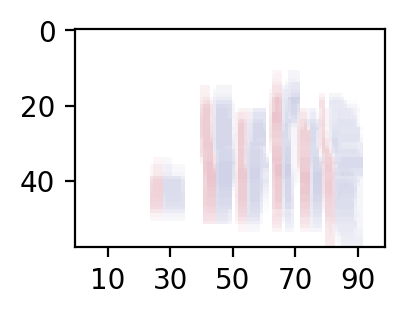

PyObject <matplotlib.image.AxesImage object at 0x000002000C2923A0>

In [10]:
ky_v, kx_v = kymographs( [ Float32.( wv .==  1 ) for wv in filt_WVs ], fun=(x)->sum(x)/length(x) )
ky_d, kx_d = kymographs( [ Float32.( wv .== -1 ) for wv in filt_WVs ], fun=(x)->sum(x)/length(x) )

waves_ = zeros( Float32, size( ky_v ) )
for i in 1:length( ky_v )
    v_ =  ky_v[i]
    d_ = -ky_d[i]
    waves_[i] = abs( v_ ) > abs( d_ ) ? v_ : d_ 
end

# "RdYlBu_r"
mp        = PyCall.pyimport( "matplotlib" )
colors_   = [ (193/255,195/255,223/255), (1.0,1.0,1.0), (228/255,179/255,190/255) ] 
colormarc = mp.colors.LinearSegmentedColormap.from_list( "marc", colors_, N=256 )

figure( figsize=(2,5), dpi=200 )
PyPlot.xticks( collect( 10:20:90 ) )

W = waves_ ./ ( abs.( waves_ ) .> 0 )
PyPlot.imshow( W, cmap=colormarc, alpha=1.0, vmin=-1.0, vmax=1.0, aspect=1.2 )